### Activations & Gradients, BatchNorm

Let's continue from where we stopped and look at the impact of initialization values in the network:

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(['.'] + list(set(char for word in words for char in word)))

itoc = { i:x for i,x in enumerate(chars) }
ctoi = { x:i for i,x in enumerate(chars) }

In [4]:
import random

def build_dataset(words, context_length):

    X, Y = [], []

    for word in words:
        context = [0] * context_length
        for ch in word + '.':
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    return (torch.tensor(X), torch.tensor(Y))

def build_dataset_split(words, context_length):
    random.seed(42)
    words = random.sample(words, len(words))     

    n1 = int(0.8 * len(words))
    n2 = int(0.9 * len(words))

    return {
        'train': build_dataset(words[:n1], context_length),
        'valid': build_dataset(words[n1:n2], context_length),
        'test': build_dataset(words[n2:], context_length)
    }

In [5]:
class MakeMore:

    def __init__(self, context_length, vocab_length, c_dim=10, h_dim=200):

        g = torch.Generator().manual_seed(420)

        # hyper parameters
        self.context_length = context_length # number of characters used to predict next character
        self.vocab_length = vocab_length # number of characters in the vocabulary
        self.c_dim = c_dim # number of dimensions used for character embedding
        self.h_dim = h_dim # number of neurons in the hidden layer

        # parameters
        self.C = torch.randn(vocab_length, c_dim,               generator=g)
        self.W1 = torch.randn(context_length * c_dim, h_dim,    generator=g)
        self.b1 = torch.randn(h_dim,                            generator=g) 
        self.W2 = torch.randn(h_dim, vocab_length,              generator=g)
        self.b2 = torch.randn(vocab_length,                     generator=g)

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        for p in self.parameters:
            p.requires_grad = True

        # tracking loss stats
        self.loss_history = []
    
    def size(self):
        # total number of parameters of this model
        return sum(p.nelement() for p in self.parameters)
    
    def train(self, X, Y, learning_rate, epochs, batch_size=32):
        
        for epoch in range(epochs):

            # mini batch construct
            ix = torch.randint(0, len(X), (batch_size,))

            # forward pass
            emb = self.C[X[ix]]
            embcat = emb.view(-1, self.context_length * self.c_dim)
            h = (embcat@self.W1 + self.b1).tanh()
            logits = h@self.W2 + self.b2
            loss = F.cross_entropy(logits, Y[ix])

            # track loss
            self.loss_history.append(loss.log10().item())
            if epoch % 10000 == 0: print(f'{loss.item()}')

            # backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()

            # update params
            for p in self.parameters:
                p.data -= learning_rate * p.grad

    def calculate_loss(self, X, Y):
        emb = self.C[X]
        h = (emb.view(-1, self.context_length * self.c_dim)@self.W1 + self.b1).tanh()
        logits = h@self.W2 + self.b2
        return F.cross_entropy(logits, Y).item()

    def plot_loss_history(self):
        plt.plot([i for i in range(len(self.loss_history))], self.loss_history)

In [6]:
context_length = 3
vocabulary_length = len(chars)

model = MakeMore(context_length, vocabulary_length)

ds = build_dataset_split(words, context_length)

X_train, Y_train = ds['train']
X_valid, Y_valid = ds['valid']
X_test, Y_test = ds['test']

In [7]:
# train model in learning blocks with decaying learning rate
def train(model, epochs=200_000, learning_rate=0.1, learning_blocks=20):
    for block in range(learning_blocks):
        lr = learning_rate * (learning_blocks + 1 - block) / (learning_blocks + 1)
        model.train(X_train, Y_train, learning_rate=lr, epochs=int(epochs/learning_blocks))

train(model)

22.569515228271484
2.096843957901001
2.3857154846191406
1.9943815469741821
2.0412380695343018
2.785888910293579
2.1129181385040283
2.013493299484253
2.3590712547302246
1.934295654296875
2.188819646835327
2.259946346282959
2.1027796268463135
2.279628038406372
2.0428242683410645
2.1403114795684814
2.2103238105773926
2.1079137325286865
2.235351085662842
2.195686101913452


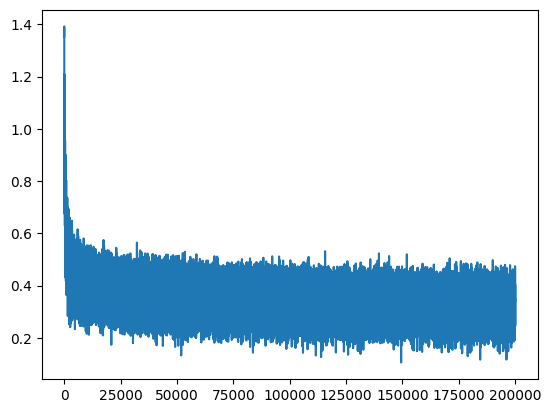

In [8]:
model.plot_loss_history()

In [9]:
model.calculate_loss(X_train, Y_train), model.calculate_loss(X_valid, Y_valid), model.calculate_loss(X_test, Y_test)

(2.119863271713257, 2.158442497253418, 2.166614055633545)

#### Fixing initial loss

Initially we can expect each character to have equal probability of being assigned:

In [10]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

But since we're assinging random values initially, the network is 'confidently wrong' and so our initial loss is very high. We end up with a loss plot that looks like a hockey stick because of that. And more importantly we waste training cycles to fix that. 

In [11]:
model = MakeMore(context_length, vocabulary_length)

model.calculate_loss(X_train, Y_train)

23.814977645874023

Looking at the last layer of our nn, we can examplify the issue:

In [12]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)

# If we luck out and the element at index 2 is the correct one has been assigned a high prob
print(f'Got lucky: {-probs[2].log()}')

# But if the correct one is at index 1 and we assigned low prob to it and high to other elements, our loss will be high
print(f'Bad luck: {-probs[1].log()}')

# If we had equal probability for each character as initially expected (any number will do as long as they are equal)
logits = torch.full((4,), 1/27.0)
probs = torch.softmax(logits, dim=0)

print(f'Equal: {logits=} {-probs[0].log()}')


Got lucky: 0.020012274384498596
Bad luck: 5.020012378692627
Equal: logits=tensor([0.0370, 0.0370, 0.0370, 0.0370]) 1.3862943649291992


Our logits are simply `h@W2 + b2`. So we can do a couple of things:

1. Initialize `b2` with `zeros`
2. Scale down `W2` by multiplying it by a small constant

In [13]:
class MakeMore:

    def __init__(self, context_length, vocab_length, c_dim=10, h_dim=200):

        g = torch.Generator().manual_seed(420)

        self.context_length = context_length 
        self.vocab_length = vocab_length 
        self.c_dim = c_dim 
        self.h_dim = h_dim

        self.C = torch.randn(vocab_length, c_dim,               generator=g)
        self.W1 = torch.randn(context_length * c_dim, h_dim,    generator=g)
        self.b1 = torch.randn(h_dim,                            generator=g) 
        self.W2 = torch.randn(h_dim, vocab_length,              generator=g) * 0.01  # Scale down
        self.b2 = torch.randn(vocab_length,                     generator=g) * 0    # Init with zeros

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        for p in self.parameters:
            p.requires_grad = True

        self.loss_history = []
    
    def size(self):
        return sum(p.nelement() for p in self.parameters)
    
    def train(self, X, Y, learning_rate, epochs, batch_size=32):
        
        for epoch in range(epochs):

            ix = torch.randint(0, len(X), (batch_size,))

            emb = self.C[X[ix]]
            embcat = emb.view(-1, self.context_length * self.c_dim)
            h = (embcat@self.W1 + self.b1).tanh()
            logits = h@self.W2 + self.b2
            loss = F.cross_entropy(logits, Y[ix])

            self.loss_history.append(loss.log10().item())
            if epoch % 10000 == 0: print(f'{loss.item()}')

            for p in self.parameters:
                p.grad = None
            loss.backward()

            for p in self.parameters:
                p.data -= learning_rate * p.grad

    def calculate_loss(self, X, Y):
        emb = self.C[X]
        h = (emb.view(-1, self.context_length * self.c_dim)@self.W1 + self.b1).tanh()
        logits = h@self.W2 + self.b2
        return F.cross_entropy(logits, Y).item()

    def plot_loss_history(self):
        plt.plot([i for i in range(len(self.loss_history))], self.loss_history)

This should reduce our initial loss dramatically:

In [14]:
model = MakeMore(context_length, vocabulary_length)

model.calculate_loss(X_train, Y_train)

3.291245460510254

And our loss plot should no longer have a hockey stick shape:

3.2346034049987793
2.5301401615142822
1.9907829761505127
1.6968883275985718
2.352738857269287


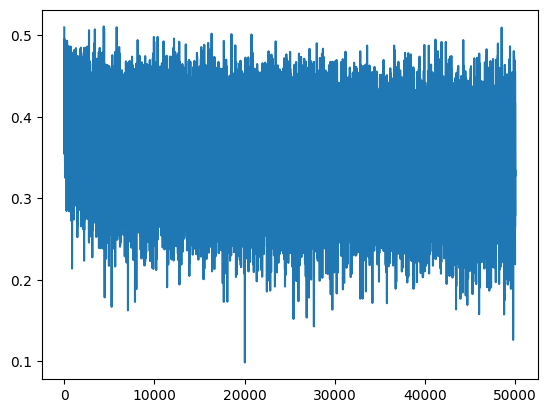

In [15]:
model.train(X_train, Y_train, learning_rate=0.1, epochs=50000)
model.plot_loss_history()

#### Fixing saturated tanh

Let's visualize the values of our hidden layer in a histogram:

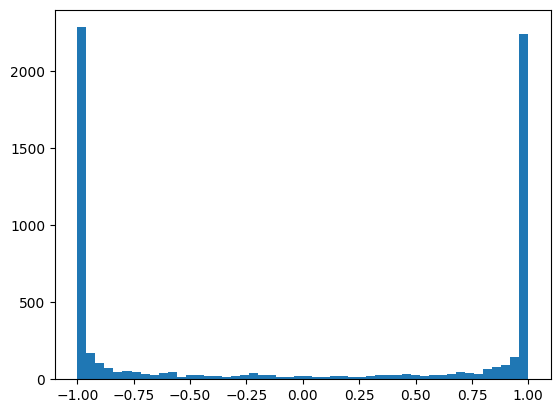

In [16]:
emb = model.C[X_train[torch.randint(0, len(X_train), (32,))]]
h_pre_activation = emb.view(-1, model.context_length * model.c_dim)@model.W1 + model.b1
h = h_pre_activation.tanh()

plt.hist(h.view(-1).tolist(), 50);


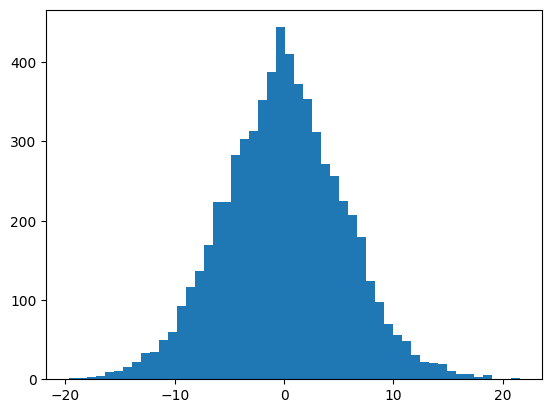

In [17]:
plt.hist(h_pre_activation.view(-1).tolist(), 50);

Cause the numbers of the preactivation values are so broad, the `tanh` is very active and resulting in a lot of `-1`s & `1`s. 

This is a big problem! The derivative of `tanh` is `(1 - tanh ** 2)`, which means `-1` and `1` values will zero the gradient update

Let's visualize how many of these we have (in white):

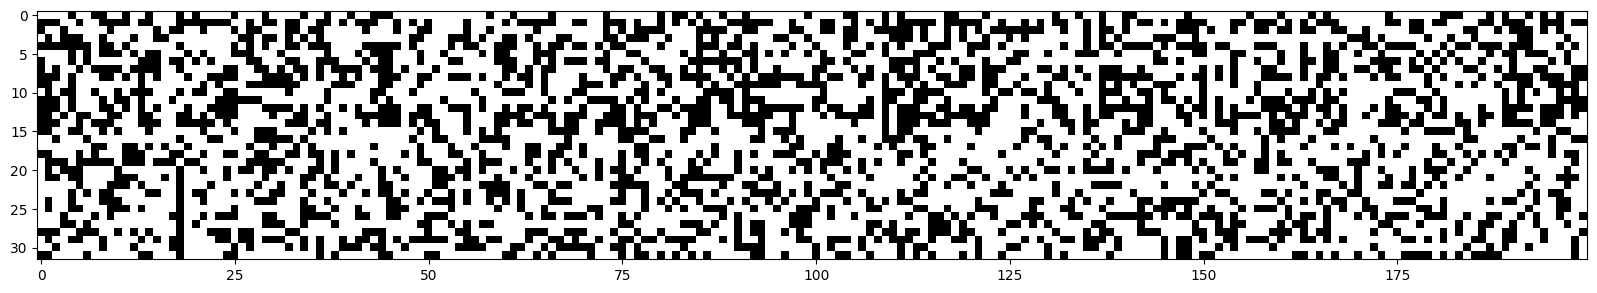

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

If we had a column completely white, no example would have activated this neuron - that would be a case of a `dead neuron`. Such cases of dead neurons can happen not only at initialization just by chance when initializing weights & bias, but it can also happen during training. A high learning rate, for example, can knock out a neuron so that no training example can activate it anymore - like a permanent brain damage.

This can happen with not only `tanh` but also `sigmoid`, `relu` or any function that has a 'squashed/flat` region. Note that `Leaky ReLU` will not suffer this problem.

![activation functions](./activation_functions.jpg)

Let's do then similar adjustments to the hidden layer as previously so that init values fall into the active region of the tanh:

1. Initialize `b1` with `zeros` or a minimal value for entropy
2. Scale down `W1` by multiplying it by a small constant

In [19]:
class MakeMore:

    def __init__(self, context_length, vocab_length, c_dim=10, h_dim=200):

        g = torch.Generator().manual_seed(420)

        self.context_length = context_length 
        self.vocab_length = vocab_length 
        self.c_dim = c_dim 
        self.h_dim = h_dim

        self.C = torch.randn(vocab_length, c_dim,               generator=g)
        self.W1 = torch.randn(context_length * c_dim, h_dim,    generator=g) * 0.2 # Scale down
        self.b1 = torch.randn(h_dim,                            generator=g) * 0.01 # init with small value or zero
        self.W2 = torch.randn(h_dim, vocab_length,              generator=g) * 0.01  
        self.b2 = torch.randn(vocab_length,                     generator=g) * 0 

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        for p in self.parameters:
            p.requires_grad = True

        self.loss_history = []
    
    def size(self):
        return sum(p.nelement() for p in self.parameters)
    
    def train(self, X, Y, learning_rate, epochs, batch_size=32):
        
        for epoch in range(epochs):

            ix = torch.randint(0, len(X), (batch_size,))

            emb = self.C[X[ix]]
            embcat = emb.view(-1, self.context_length * self.c_dim)
            h = (embcat@self.W1 + self.b1).tanh()
            logits = h@self.W2 + self.b2
            loss = F.cross_entropy(logits, Y[ix])

            self.loss_history.append(loss.log10().item())
            if epoch % 10000 == 0: print(f'{loss.item()}')

            for p in self.parameters:
                p.grad = None
            loss.backward()

            for p in self.parameters:
                p.data -= learning_rate * p.grad

    def calculate_loss(self, X, Y):
        emb = self.C[X]
        h = (emb.view(-1, self.context_length * self.c_dim)@self.W1 + self.b1).tanh()
        logits = h@self.W2 + self.b2
        return F.cross_entropy(logits, Y).item()

    def plot_loss_history(self):
        plt.plot([i for i in range(len(self.loss_history))], self.loss_history)

And let's plot our histogram again:

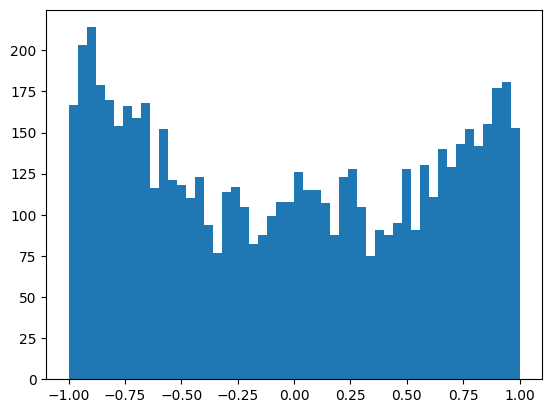

In [20]:
model = MakeMore(context_length, vocabulary_length)

emb = model.C[X_train[torch.randint(0, len(X_train), (32,))]]
h_pre_activation = emb.view(-1, model.context_length * model.c_dim)@model.W1 + model.b1
h = h_pre_activation.tanh()

plt.hist(h.view(-1).tolist(), 50);

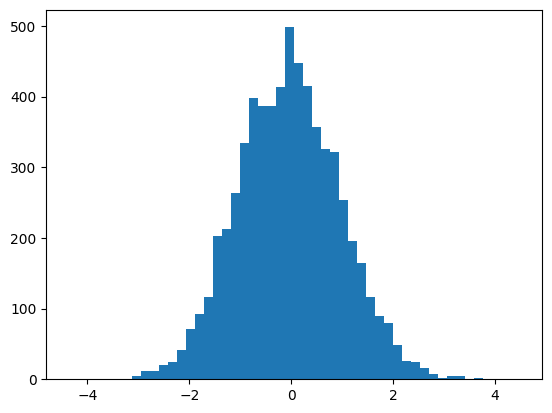

In [21]:
plt.hist(h_pre_activation.view(-1).tolist(), 50);

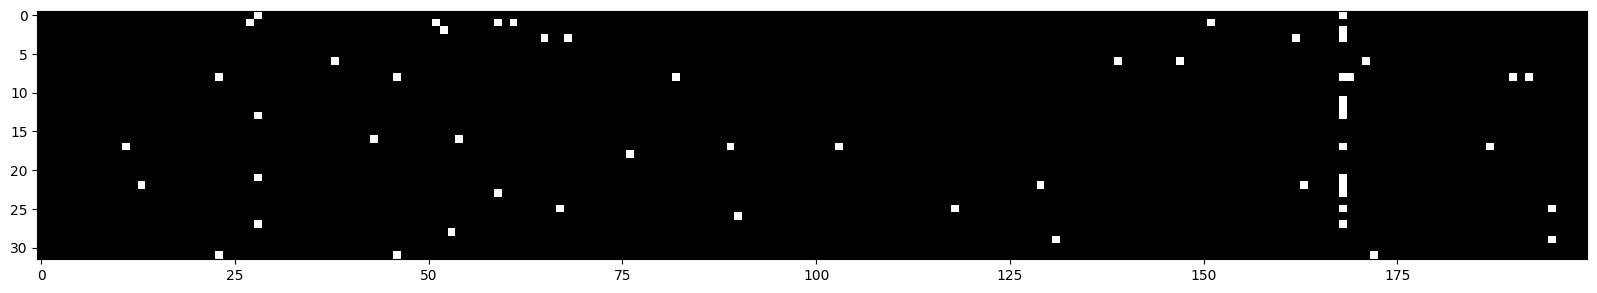

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

No inactive neurons!

#### Kaiming Init

Analyzing matrix multiplication impact on gaussian distrubution;

tensor(0.0148) tensor(1.0021)
tensor(-0.0157) tensor(5.4812)


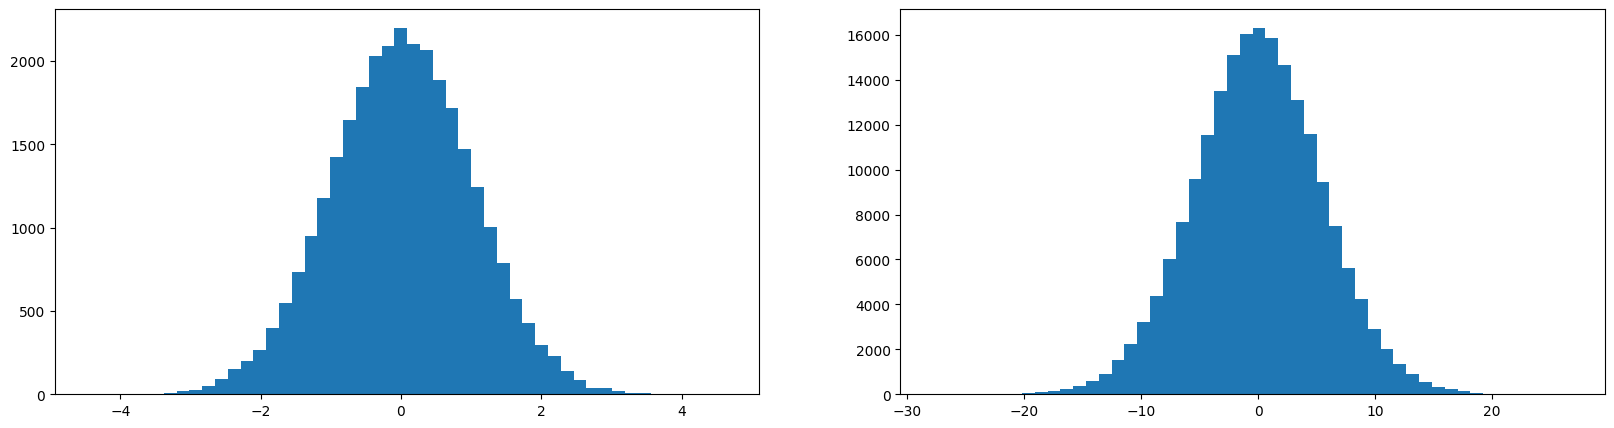

In [23]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200)

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

def plot_gaussian(x, y):
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.hist(x.view(-1).tolist(), 50);
    plt.subplot(122)
    plt.hist(y.view(-1).tolist(), 50);

plot_gaussian(x, y)

If we want to preserve the standard deviation, we have to divide by the square root of the fan in:

tensor(-0.0054) tensor(1.0003)
tensor(-0.0043) tensor(0.9894)


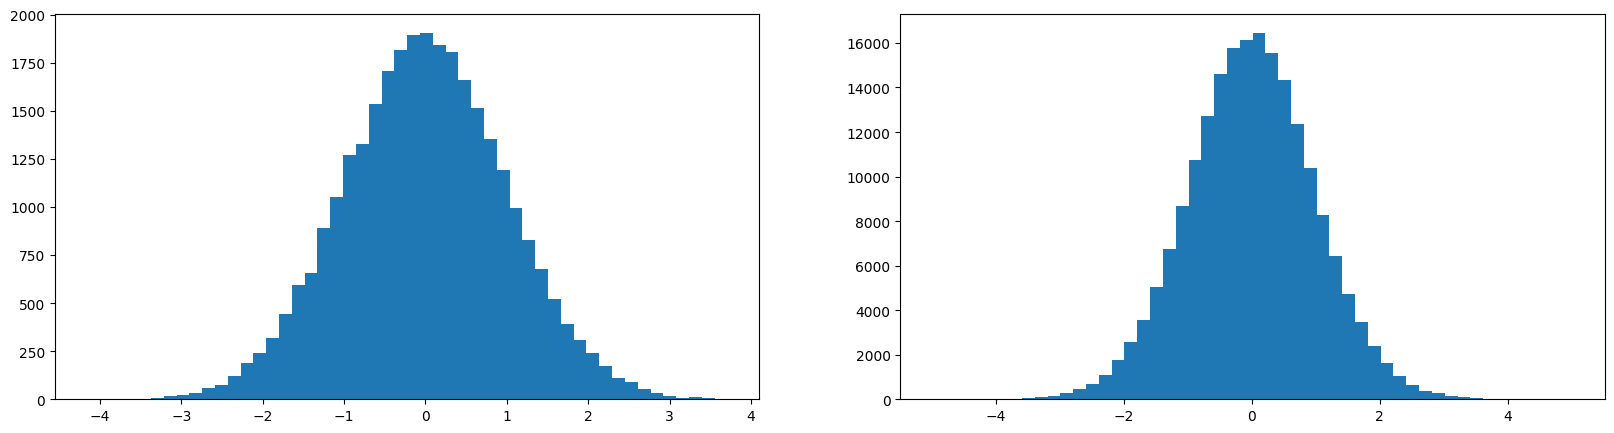

In [24]:
x = torch.randn(1000, 30)
w = torch.randn(30, 200) * (1 / (30 ** .5))

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())

plot_gaussian(x, y)

https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_

#### BatchNorm

Normalize the layer by the input (batch)

Pros:
- We don't have to address each layer individually
- Entropy is added the logits reducing likelihood of overfitting (regularizer)

Cons:
- Tying logits output to batch construct, which exists only for efficiency
- NN expects a batch as input now, which is weird for inference

In [30]:
class MakeMore:

    def __init__(self, context_length, vocab_length, c_dim=10, h_dim=200):

        g = torch.Generator().manual_seed(420)

        self.context_length = context_length 
        self.vocab_length = vocab_length 
        self.c_dim = c_dim 
        self.h_dim = h_dim

        self.C = torch.randn(vocab_length, c_dim,               generator=g)

        ##### BatchNorm Layer ######
        
        self.W1 = torch.randn(context_length * c_dim, h_dim,    generator=g) 
        # Bias doesn't have any effect with BatchNorm since we calculate mean and subtract it, so we can remove it
        ## self.b1 = torch.randn(h_dim,                            generator=g) 
        # Track mean & standard deviation for normalization
        self.bnmean = torch.zeros((1, h_dim))
        self.bnstd = torch.ones((1, h_dim))
        # Scale and shift so that normalization has impact initially only
        self.bngain = torch.ones((1, h_dim))
        self.bnbias = torch.zeros((1, h_dim))

        #############################

        self.W2 = torch.randn(h_dim, vocab_length,              generator=g) * 0.01  
        self.b2 = torch.randn(vocab_length,                     generator=g) * 0 

        # We add bngain and bnbias as these will be trained. 
        # bnmean and bnstd will not be trained, just tracked. So we don't consier these as model params.
        self.parameters = [self.C, self.W1, self.W2, self.b2, self.bngain, self.bnbias]

        for p in self.parameters:
            p.requires_grad = True

        self.loss_history = []
    
    def size(self):
        return sum(p.nelement() for p in self.parameters)
    
    def train(self, X, Y, learning_rate, epochs, batch_size=32):
        
        for epoch in range(epochs):

            ix = torch.randint(0, len(X), (batch_size,))

            emb = self.C[X[ix]]
            embcat = emb.view(-1, self.context_length * self.c_dim)

            ##### BatchNorm Layer ######

            # Remove bias since it not longer has an effect due to normalization
            hpreact = embcat@self.W1 # + self.b1 

            # calculate mean and std for this batch
            bnmeani = hpreact.mean(0, keepdim=True)
            bnstdi = hpreact.std(0, keepdim=True)

            # normalize activation input to be unit gaussian
            hpreact = self.bngain * (hpreact - bnmeani) / bnstdi + self.bnbias

            # keep track of the global (used later at inference)
            with torch.no_grad():
                self.bnmean = self.bnmean * 0.999 + bnmeani * 0.001
                self.bnstd =  self.bnstd * 0.999 + bnstdi * 0.001

            #############################

            h = hpreact.tanh()
            logits = h@self.W2 + self.b2
            loss = F.cross_entropy(logits, Y[ix])

            self.loss_history.append(loss.log10().item())
            if epoch % 10000 == 0: print(f'{loss.item()}')

            for p in self.parameters:
                p.grad = None
            loss.backward()

            for p in self.parameters:
                p.data -= learning_rate * p.grad

    def calculate_loss(self, X, Y):
        emb = self.C[X]
        embcat = emb.view(-1, self.context_length * self.c_dim)
        hpreact = embcat@self.W1
        hpreact = self.bngain * (hpreact - self.bnmean) / self.bnstd + self.bnbias
        h = hpreact.tanh()
        logits = h@self.W2 + self.b2
        return F.cross_entropy(logits, Y).item()

    def plot_loss_history(self):
        plt.plot([i for i in range(len(self.loss_history))], self.loss_history)

In [31]:
model = MakeMore(context_length, vocabulary_length)

train(model)

model.calculate_loss(X_train, Y_train), model.calculate_loss(X_valid, Y_valid), model.calculate_loss(X_test, Y_test)

3.3068339824676514
2.151801347732544
2.3146860599517822
2.1554994583129883
2.122629404067993
2.0142176151275635
2.003950834274292
1.7873883247375488
1.8940154314041138
1.919520616531372
1.999892234802246
2.3037185668945312
2.344263792037964
2.022942304611206
1.8432320356369019
2.125884771347046
2.2483367919921875
1.9550634622573853
1.973027229309082
2.1256909370422363


(2.1089324951171875, 2.1390960216522217, 2.146348237991333)